In [12]:
# =================================================================================
# IMPORTS
# =================================================================================
import _thread
import os
import re
import albumentations
import matplotlib.image as mpimg
import numpy as np
import torch
import torch.utils.data
import torchvision
import tqdm
from PIL import Image
from albumentations.pytorch import ToTensorV2
from torchvision.transforms.functional import resize
import random


# =================================================================================
# GENERAL PARAMETERS
# =================================================================================
random.seed(127)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE: ", DEVICE)
SUBMISSION_THRESHOLD = 0.25 # Given, DO NOT change it


# =================================================================================
# PATHS
# =================================================================================
Train_image_path = "data/training/images"
Train_mask_path = "data/training/groundtruth"
Validation_image_path = "data/validating/images"
Validation_mask_path = "data/validating/groundtruth"

DEVICE= cuda


# Data processing

In [4]:
class RoadDataset(torch.utils.data.Dataset):
    """
    The class RoadDataset loads the data and executes the pre-processing operations on it.
    More specifically, it re-applies the specified transform every time data is fetched via a dataloader.
    """

    def __init__(
        self,
        image_path: str,
        mask_path: str,
        transform,
    ):
        # Remember transforms
        self.transform = transform

        # Load images and masks
        self.images = self.load_images(image_path)
        self.masks = self.load_images(mask_path)

        # Augmented images and masks
        self.images_augmented = []
        self.masks_augmented = []

        # Data augmentation using transforms
        for i in range(len(self.images)):
            output = self.transform(image=self.images[i], mask=self.masks[i])
            self.images_augmented.append(output["image"])
            self.masks_augmented.append(output["mask"])

    def get_images(self):
        return self.images, self.masks

    @staticmethod
    def load_images(image_path):
        """This method loads the images from the given path"""
        images = []
        for img in os.listdir(image_path):
            path = os.path.join(image_path, img)
            image = Image.open(path)
            images.append(np.asarray(image))

        return np.asarray(images)

    def augment(self, index):
        """This method applies data augmentation to the images again to change precedent augmentation transformations"""
        output = self.transform(image=self.images[index], mask=self.masks[index])
        self.images_augmented[index] = output["image"]
        self.masks_augmented[index] = output["mask"]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        """This method returns the image at a certain position and its mask"""
        image = self.images_augmented[index]
        mask = self.masks_augmented[index]

        # Start a new thread to augment the data (thread level parallelism)
        _thread.start_new_thread(self.augment, (index,))

        # Return scaled image and mask
        return (image / 255), (mask.unsqueeze(0) > 200).float()


def get_loader(
    data_path: str,
    mask_path: str,
    transform,
    batch_size: int = 4,
) -> torch.utils.data.DataLoader:
    """Create the DataLoader class"""
    # Use our dataset and defined transformations
    dataset = RoadDataset(
        data_path,
        mask_path,
        transform,
    )

    # Use the dataset in the torch dataloader
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size, # Specify batch size
        shuffle=True, # Shuffle the data to avoid learning the order
        pin_memory=True, # Copy tensors to CUDA pinned memory
        generator=torch.Generator().manual_seed(127), # Set seed for reproducibility
    )



# Models

In [5]:
# ================================================================================================
# UNET
# ================================================================================================
# ------------------------------------------------------------------------------
# USEFUL FUNCTIONS
# ------------------------------------------------------------------------------
class DoubleConv(torch.nn.Module):
    """Performs a double convolution (used once every up/down)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, out_channels, kernel_size=3, padding=1, bias=False
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(
                out_channels, out_channels, kernel_size=3, padding=1, bias=False
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor):
        return self.double_conv(x)

class Down(torch.nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(torch.nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = torch.nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        del x1
        del x2
        torch.cuda.empty_cache()
        return self.conv(x)


# ------------------------------------------------------------------------------
# GENERAL UNET
# ------------------------------------------------------------------------------
class UNet(torch.nn.Module):
    """U-Net as presented in the paper "U-Net: Convolutional Networks for Biomedical Image Segmentation" (https://arxiv.org/pdf/1505.04597.pdf)"""
    def __init__(self):
        # Module init
        super().__init__()

        # Define layers as presented in the paper "U-Net: Convolutional Networks for Biomedical
        # Image Segmentation" (https://arxiv.org/pdf/1505.04597.pdf) with batch normalization

        # Encoder part
        self.inconv = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # Decoder part
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        # Output part: convert to 1 channel (binary)
        self.outconv = torch.nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder part
        x1 = self.inconv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder part
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output part: binary with help of sigmoid
        logits = self.outconv(x)

        # Free memory of GPU
        torch.cuda.empty_cache()

        # Return output
        return logits


# ================================================================================================
# LINKNET
# ================================================================================================
class LinkNetDecoderBlock(torch.nn.Module):
    """Decoder block of LinkNet"""
    def __init__(self, in_channel, out_channel):
        # Module init
        super(LinkNetDecoderBlock, self).__init__()

        # Define decoder layers as presented in the paper "LinkNet: Exploiting Encoder Representations
        # for Efficient Semantic Segmentation" (https://arxiv.org/pdf/1707.03718.pdf)
        self.conv1 = torch.nn.Conv2d(in_channel, in_channel // 4, kernel_size=1)
        self.bn1 = torch.nn.BatchNorm2d(in_channel // 4)
        self.up = torch.nn.ConvTranspose2d(
            in_channel // 4,
            in_channel // 4,
            kernel_size=3, # 3x3 kernel
            stride=2, # downsampling by 2
            padding=1, # padding to keep same size
            output_padding=1, # output padding to keep same size
        )
        self.bn2 = torch.nn.BatchNorm2d(in_channel // 4)
        self.conv2 = torch.nn.Conv2d(in_channel // 4, out_channel, kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(out_channel)

    def forward(self, x):
        # Again, same as in the paper for ReLU and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.up(x)
        x = self.bn2(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = torch.nn.functional.relu(x)
        return x


class LinkNet(torch.nn.Module):
    """LinkNet model as presented in the paper LinkNet: Exploiting Encoder Representations for Efficient Semantic Segmentation (https://arxiv.org/pdf/1707.03718.pdf)"""
    def __init__(
        self,
        encoder,
        channels=(64, 128, 256, 512), # Potentially different channel widths depending on PyTorch resnet model
    ):
        # Module init
        super().__init__()

        # We use 4 different channel widths, like in the paper
        assert len(channels) == 4

        # While the decoder is the same as in the paper, the encoder is not: we use a custom encoder (ResNet) for better performance
        self.conv1 = encoder.conv1
        self.bn1 = encoder.bn1
        self.maxpool = encoder.maxpool
        self.encoders = torch.nn.ModuleList()
        self.encoders.append(encoder.layer1)
        self.encoders.append(encoder.layer2)
        self.encoders.append(encoder.layer3)
        self.encoders.append(encoder.layer4)

        # Decoder part, same as in the paper (again)
        self.decoders = torch.nn.ModuleList()
        channels = channels[::-1] # Reverse channels
        for i in range(len(channels) - 1):
            self.decoders.append(LinkNetDecoderBlock(channels[i], channels[i + 1]))
        self.decoders.append(LinkNetDecoderBlock(channels[-1], channels[-1]))
        self.up = torch.nn.ConvTranspose2d(channels[-1], 32, kernel_size=3, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=2)
        self.conv3 = torch.nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x): # NEED CHECK
        # Encoder part
        # We save the output of each encoder layer to use it in the decoder part
        x_save = []

        # Same as defined on resnet for pytorch: https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.maxpool(x)
        for enc in self.encoders:
            x = enc(x)
            x_save .append(x)

        # Decoder part
        x_save  = x_save[::-1] # Reverse x_save
        for i in range(3):
            x = self.decoders[i](x)

            # Resize x to the size of the next decoder layer
            if x.shape[2:] != x_save[i + 1].shape[2:]:
                x = resize(x, x_save[i + 1].shape[2:])

            # Add the output of the encoder layer to the output of the decoder layer
            x = x + x_save[i + 1]
        x = self.decoders[3](x)

        # Output part after decoder, same as in the paper
        x = self.up(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x)

        # Return output
        return x


# Training

In [6]:
def f1(pred, label):
    """Compute F1 score"""
    # Flatten tensors
    pred = pred.view(-1)
    label = label.view(-1)

    # True positive, false positive and negative
    tp = (label * pred).sum().to(torch.float32)
    fp = ((1 - label) * pred).sum().to(torch.float32)
    fn = (label * (1 - pred)).sum().to(torch.float32)

    # Precision and recall calculation
    eps = 1e-7
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)

    # F1 score is returned
    return 2 * precision * recall / (precision + recall + eps), precision, recall


def compute_metrics(loader, model, device):
    """Compute the accuracy rate on the given dataset with the input model"""
    # Set model to evaluation mode
    model.eval()

    # Dictionnary to store metrics
    logs = dict()

    # Parameters to compute metrics
    num_correct = 0
    num_pixels = 0

    # Metrics computation
    f1_score = 0
    precision = 0
    recall = 0

    # Eval mode, so no gradient computation because no training
    with torch.no_grad():
        # Iterate over the dataset
        for x, y in loader:
            # Move data to device
            x = x.to(device)
            y = y.to(device)

            # Compute output via the model
            output = model(x)

            # Drop the first dimension of the output (batch size)
            output = output[:, -1, :, :].unsqueeze(1)

            # Apply sigmoid to the output and round it to 0 or 1 to get the prediction for each pixel
            pred: torch.Tensor = (torch.sigmoid(output) >= 0.5).float()

            # Compute the number of correct pixels and the total number of pixels
            num_correct += torch.sum(pred == y).item()
            num_pixels += torch.numel(pred)

            # Compute F1 score
            f1_pixel, precision_pixel, recall_pixel = f1(pred, y)
            f1_score += f1_pixel.item()
            precision += precision_pixel.item()
            recall += recall_pixel.item()

    # Add metrics to the dictionnary and multiply by 100 to get a percentage
    logs["acc"] = 100*num_correct/num_pixels 
    logs["f1 score"] = 100*f1_score/len(loader)
    logs["precision"] = 100*precision/len(loader)
    logs["recall"] = 100*recall/len(loader)

    # Set model back to training mode
    model.train()

    # Return logs
    return logs

In [ ]:
class DiceLoss(nn.Module):
    """Dice loss"""
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth # Smoothing factor

    def forward(self, logits, targets):
        # Determine probabilities
        probs = torch.sigmoid(logits)

        # Flatten
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)

        # Find intersection and compute dice
        intersection = (m1 * m2)
        score = (2. * intersection.sum(1) + self.smooth) / (m1.sum(1) + m2.sum(1) + self.smooth)
        score = 1 - score.sum() / num

        # Return score
        return score

In [7]:
def epoch(model, loader, optimizer, criterion, scaler):
    """Train the model for one epoch"""
    # Total loss for the epoch
    total_loss = 0

    # Iterate over the dataset
    for data, target in loader:
        # Move data to device
        data = data.to(DEVICE)
        target = target.to(DEVICE)

        # Compute output via the model with mixed precision to speed up training
        with torch.cuda.amp.autocast():
            # Compute output
            output = model(data)

            # Define local loss variable
            loss = 0
            # Compute loss for each output
            for i in range(output.shape[1]):
                # Get the output for the current time step, add a dimension to match the target shape
                pred = output[:, i, :, :].unsqueeze(1)

                # Compute the loss for the current time step
                loss += criterion(pred, target)

            # Add the loss for the current time step to the total loss
            total_loss += loss.item()

        # Backpropagation and scaler to avoid vanishing gradient
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # Return total loss
    return total_loss


def train(
    model,
    model_name,
    train_loader,
    validation_loader,
    lr: float = 1.0e-4, # Learning rate
    epochs: int = 10, # Number of epochs
    with_dice: bool = False, # Use dice loss instead of BCE
):
    """Train the model"""
    # Create the log file
    log_file_name = os.path.relpath(os.path.join("logs", model_name + ".csv"))
    with open(log_file_name, "w") as f:
        f.write("epoch,loss,f1,iou,accuracy,precision,recall\n")

    # Create a checkpoint file to store the best model
    model_file_name = os.path.join("checkpoints", model_name + ".pth")

    # Define the criterion
    if with_dice:
        criterion = DiceLoss()
    else:
        criterion = torch.nn.BCEWithLogitsLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler and scaler
    lambda1 = lambda epoch: 0.99 ** epoch
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=lr)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    scaler = torch.cuda.amp.GradScaler()

    # Define the data augmentation used for the training set, and also create the data loader for it


    # Variables to store current best metrics
    max_f1 = 0
    min_loss = 0.1

    # Train the model, then save the training logs and the best model
    loop = tqdm.tqdm(range(epochs)) 
    for e in tqdm.tqdm(range(epochs)):
        # Train the model for one epoch and get the loss
        loss = epoch(model, train_loader, optimizer, criterion, scaler)

        # Take a step in the scheduler
        scheduler.step()

        # Compute the metrics on the validation set
        metrics = compute_metrics(validation_loader, model, DEVICE)

        # Save the model if it surpasses the current best metrics
        # in terms of F1 score
        if metrics["f1 score"] > max_f1:
            max_f1 = metrics["f1 score"]
            if max_f1 > 80.0:
                torch.save(model, model_file_name + ".maxf1")

        # or in terms of loss
        if loss < min_loss:
            torch.save(model, model_file_name + ".minloss")
            min_loss = loss

        # Save the logs into a file
        with open(log_file_name, "a") as f:
            f.write(
                "{},{},{},{},{},{},{},{}\n".format(
                    e,
                    loss,
                    metrics["f1 score"],
                    0,
                    metrics["acc"],
                    metrics["precision"],
                    metrics["recall"],
                    min_loss
                )
            )

        # Update the progress bar
        loop.set_postfix(loss=loss, f1_score=metrics["f1 score"], max_f1=max_f1, min_loss=min_loss)

    # Save the logs into a file
    torch.save(model, model_file_name)

In [8]:
# RUN THIS CELL ==============================================================================
# Define the data augmentation with albumentations for the training set and convert it to tensor
train_transform = albumentations.Compose(
    [
        albumentations.Flip(p=0.5),
        albumentations.Transpose(p=0.5),
        albumentations.Rotate(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5),
        albumentations.CoarseDropout(min_holes= 5, max_holes=20, min_height=5, max_height=20, min_width=5, max_width=20, p=0.5),
        albumentations.OpticalDistortion(p=0.5),
        albumentations.GridDistortion(p=0.5),
        albumentations.ElasticTransform(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.PiecewiseAffine(p=0.5),
        ToTensorV2(),
    ]
)

# Create the data loader for the training
train_loader = get_loader(
    data_path=Train_image_path,
    mask_path=Train_mask_path,
    transform=train_transform,
    batch_size=32, # Choose the batch size
)

In [9]:
# Define the data augmentation used for the validation set and convert it to tensor
val_transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomRotate90(p=0.5),
        ToTensorV2(),
    ]
)

# Create the data loader for the validation set
val_loader = get_loader(
    data_path=Validation_image_path,
    mask_path=Validation_mask_path,
    transform=val_transform,
    batch_size=32, # Choose the batch size
)

# Actual training

## BCE loss with distortions

In [ ]:
train(
    model=UNet().to(DEVICE),
    model_name="unet", # Choose the model name
    epochs=1000, # Choose the number of epochs
    train_loader=train_loader,
    validation_loader=val_loader,
)

100%|██████████| 1000/1000 [1:54:06<00:00,  6.85s/it, f1_score=87.2, loss=1.09, max_f1=89.5]


In [ ]:
train(
    model=LinkNet(
        encoder=torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        ),
        channels=(64, 128, 256, 512),
    ).to(DEVICE),
    model_name="linknet18",
    epochs=1000,
    train_loader=train_loader,
    validation_loader=val_loader,
)

100%|██████████| 1000/1000 [1:47:39<00:00,  6.46s/it, f1_score=87.5, loss=0.962, max_f1=88.8]


In [ ]:
train(
    model=LinkNet(
        encoder=torchvision.models.resnet34(
            weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1
        ),
        channels=(64, 128, 256, 512),
    ).to(DEVICE),
    model_name="linknet34",
    epochs=1000,
    train_loader=train_loader,
    validation_loader=val_loader,
)

100%|██████████| 1000/1000 [1:54:06<00:00,  6.85s/it, f1_score=88.3, loss=0.921, max_f1=89.4]   


In [ ]:
train(
    model=LinkNet(
        encoder=torchvision.models.resnet50(
            weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
        ),
        channels=(256, 512, 1024, 2048),
    ).to(DEVICE),
    model_name="linknet50",
    epochs=1000,
    train_loader=train_loader,
    validation_loader=val_loader,
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/oancea/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%
100%|██████████| 1000/1000 [2:02:59<00:00,  7.38s/it, f1_score=86.2, loss=0.678, max_f1=89.2] 


In [ ]:
train(
    model=LinkNet(
        encoder=torchvision.models.resnet101(
            weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V2
        ),
        channels=(256, 512, 1024, 2048),
    ).to(DEVICE),
    model_name="linknet101",
    epochs=1000,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [124]:
train(
    model=LinkNet(
        encoder=torchvision.models.resnet152(
            weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2
        ),
        channels=(256, 512, 1024, 2048),
    ).to(DEVICE),
    model_name="linknet152",
    epochs=2000,
    train_loader=train_loader,
    validation_loader=val_loader,
)

100%|██████████| 2000/2000 [1:47:37<00:00,  3.23s/it, f1_score=88.6, loss=0.0918, max_f1=89.5, min_loss=0.08]    


## BCE loss without distortions

In [ ]:
train(
    model=UNet().to(DEVICE),
    model_name="unet_no_distortion",
    epochs=1000,
    train_loader=train_loader_no_distortion,
    validation_loader=val_loader,
)

## Dice loss with distortions

# Create submissions

In [119]:
def patch_to_label(patch):
    df = np.mean(patch)
    if df > SUBMISSION_THRESHOLD:
        return 1
    else:
        return 0
    
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
    
def separate_image_into_patches(image, patch_size=400):
    """ Converts a 608x608 image into four 400x400 images that are situated in its corners"""
    # patches = []
    patch0 = image[0:patch_size, 0:patch_size]
    # patches.append(patch0)
    patch1 = image[0:patch_size, -patch_size:]
    # patches.append(patch1)
    patch2 = image[-patch_size:, 0:patch_size]
    # patches.append(patch2)
    patch3 = image[-patch_size:, -patch_size:]
    # patches.append(patch3)

    # return patches
    return patch0, patch1, patch2, patch3

def combine_patches_into_image(patches, patch_size=400):
    # Parameters
    side_length = 608
    image = np.zeros((side_length, side_length))
    
    # Replace image
    image[0:patch_size, 0:patch_size] = patches[0]
    image[0:patch_size, -patch_size:] = patches[1]
    image[-patch_size:, 0:patch_size] = patches[2]
    image[-patch_size:, -patch_size:] = patches[3]
    offset_1 = side_length - patch_size
    offset_2 = 2*patch_size - side_length

    # Sum results of the 4 patches in the middle
    image[offset_1:-offset_1, offset_1:-offset_1] = (patches[0][offset_1:, offset_1:] + patches[1][offset_1:, :-offset_1] + patches[2][:-offset_1, offset_1:] + patches[3][:-offset_1, :-offset_1])/4
    
    # Return fusionned image
    return image

def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    print(image_filename, os.path.basename(image_filename))
    img_number = int(re.search(r"\d+", os.path.basename(image_filename)).group(0))
    print(img_number)
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i : i + patch_size, j : j + patch_size]
            label = patch_to_label(patch)
            yield ("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, "w") as f:
        f.write("id,prediction\n")
        for fn in image_filenames:
            f.writelines("{}\n".format(s) for s in mask_to_submission_strings(fn))


def create_postprocessing_images(images, rotations, transposes):
    """Apply transformations to the image and return different prospectives"""
    ims = []
    for image in images:
        for rotation in rotations:
            # im = albumentations.rotate(image, rotation)[:400,:400]
            im = albumentations.rotate(image, rotation)
            # ims.append(im)
            tmp, tmp1, tmp2, tmp3 = separate_image_into_patches(image=im)
            ims.append(tmp)
            ims.append(tmp1)
            ims.append(tmp2)
            ims.append(tmp3)
            # ims.append(albumentations.rotate(image, rotation))
            if transposes:
                im = albumentations.hflip(image)
                tmp, tmp1, tmp2, tmp3 = separate_image_into_patches(albumentations.rotate(im, rotation))
                ims.append(tmp)
                ims.append(tmp1)
                ims.append(tmp2)
                ims.append(tmp3)
                # ims.append(albumentations.rotate(im, rotation))
    ims = np.array(ims)
    # print(ims[0])
    # ims = separate_image_into_patches(ims)
    ims = torch.tensor(ims).transpose(1, -1).transpose(2, -1).float()
    return ims


# def combine_postprocessing_images(imagess, rotations, transposes):
def combine_postprocessing_images(images, rotations, transposes):
    """Combine predictions of different prospectives"""
    outputs = []
    index = 0
    while index < len(images):
        output = np.zeros(images[0].shape)
        for rotation in rotations:
            # im = images[index, 0]
            im = images[index]
            output += albumentations.rotate(im, -rotation)
            index += 1
            if transposes:
                # im = images[index, 0]
                im = images[index]
                im = albumentations.rotate(im, -rotation)
                output += albumentations.hflip(im)
                index += 1
        output = output / len(images)
        outputs.append(output)
    return np.array(outputs)


def create_submission(model_name: str):
    # Parameters
    rotations=[90]
    transposes = False
    model_file_name = os.path.join("checkpoints", model_name + ".pth.maxf1")
    model = torch.load(model_file_name, map_location=torch.device(DEVICE)).to(DEVICE)
    model.eval()

    # Create the directory to store the predictions
    path = "data/test_set_images/test_1/test_1.png"
    pred_path = "predictions/" + model_name + "_temp"
    if not os.path.exists(pred_path):
        os.makedirs(pred_path)

    # For each image, apply postprocessing augmentation, make predictions and save predictions
    img_path = path
    # im = np.asarray(Image.open(img_path)) / 255
    im = np.asarray(Image.open(img_path)) 
    print(im.shape)
    ims = create_postprocessing_images(
        [im], rotations=rotations, transposes=transposes
    )

    with torch.no_grad():
        images = []
        for i in range(0, len(ims)//4, 4):
        # for i in range(2):
            output0 = model(ims[i].unsqueeze(0).to(DEVICE)).cpu().detach().numpy()
            output1 = model(ims[i+1].unsqueeze(0).to(DEVICE)).cpu().detach().numpy()
            output2 = model(ims[i+2].unsqueeze(0).to(DEVICE)).cpu().detach().numpy()
            output3 = model(ims[i+3].unsqueeze(0).to(DEVICE)).cpu().detach().numpy()
            
            # TEST
            predict = sigmoid(output0[0,0])
            predict[predict < 0.5] = 0
            predict[predict >= 0.5] = 1
            predict *= 255 
            final_image = Image.fromarray(predict).convert("L")
            print("0", rotations[i])
            display(final_image)
            
            predict = sigmoid(output1[0,0])
            predict[predict < 0.5] = 0
            predict[predict >= 0.5] = 1
            predict *= 255 
            final_image = Image.fromarray(predict).convert("L")
            print("1", rotations[i])
            display(final_image)
            
            predict = sigmoid(output2[0,0])
            predict[predict < 0.5] = 0
            predict[predict >= 0.5] = 1
            predict *= 255 
            final_image = Image.fromarray(predict).convert("L")
            print("2", rotations[i])
            display(final_image)
            
            predict = sigmoid(output3[0,0])
            predict[predict < 0.5] = 0
            predict[predict >= 0.5] = 1
            predict *= 255 
            final_image = Image.fromarray(predict).convert("L")
            print("3", rotations[i])
            display(final_image)
            
            
            # tmp = combine_patches_into_image([output0[0,0],output1[0,0],output2[0,0],output3[0,0]])
            # predict = sigmoid(tmp)
            # predict[predict < 0.5] = 0
            # predict[predict >= 0.5] = 1
            # predict *= 255
            
            # final_image = Image.fromarray(predict).convert("L")
            # print("combined", rotations[i])
            # display(final_image)
            # albumentations.rotate(predict, -rotations[i])
            # final_image = Image.fromarray(predict).convert("L")
            # print("Rotated", rotations[i])
            # display(final_image)
            # print("=======================================================================================================================================")

#             tmp = combine_patches_into_image([output0[0,0],output1[0,0],output2[0,0],output3[0,0]])
#             tmp = sigmoid(tmp)
#             images.append(tmp)

#     predict = combine_postprocessing_images(
#         images, rotations=rotations, transposes=transposes
#     ).reshape((608, 608))
#     predict[predict < 0.5] = 0
#     predict[predict >= 0.5] = 1
#     predict *= 255
    # Image.fromarray(im).convert("L").save(
    #     os.path.join(pred_path, "1") + ".png"
    # )

(608, 608, 3)
0 90


<ipython-input-149-33e3c9906e5e>:9: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


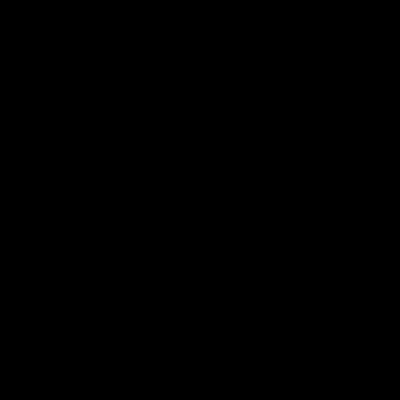

1 90


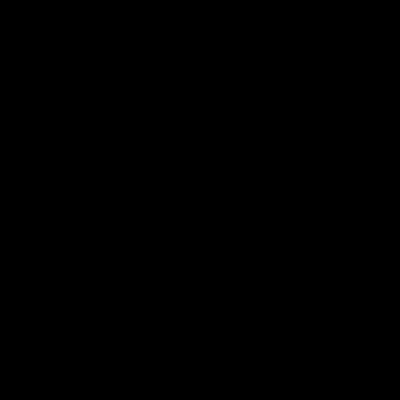

2 90


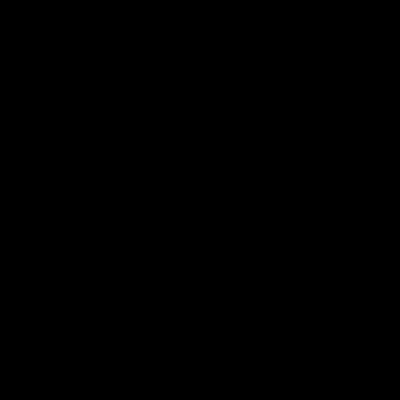

3 90


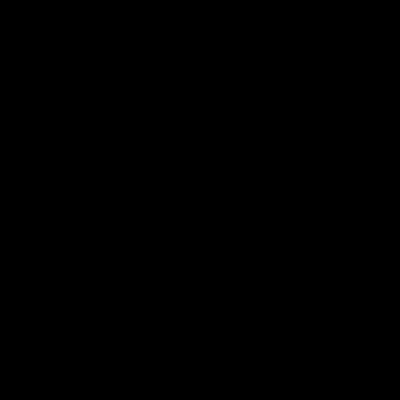

In [ ]:
# create_submission("unet")
# create_submission("linknet18")
# create_submission("linknet34")
# create_submission("linknet50")
# create_submission("linknet101")
create_submission("linknet152")

In [13]:
def patch_to_label(patch):
    df = np.mean(patch)
    if df > SUBMISSION_THRESHOLD:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    print(image_filename, os.path.basename(image_filename))
    img_number = int(re.search(r"\d+", os.path.basename(image_filename)).group(0))
    print(img_number)
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i : i + patch_size, j : j + patch_size]
            label = patch_to_label(patch)
            yield ("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, "w") as f:
        f.write("id,prediction\n")
        for fn in image_filenames:
            f.writelines("{}\n".format(s) for s in mask_to_submission_strings(fn))


def create_postprocessing_images(images, rotations, transposes):
    """Apply transformations to the image and return different prospectives"""
    ims = []
    for image in images:
        for rotation in rotations:
            ims.append(albumentations.rotate(image, rotation))
            if transposes:
                im = albumentations.hflip(image)
                ims.append(albumentations.rotate(im, rotation))
    ims = np.array(ims)
    ims = torch.tensor(ims).transpose(1, -1).transpose(2, -1).float()
    return ims


def combine_postprocessing_images(images, rotations, transposes):
    """Combine predictions of different prospectives"""
    outputs = []
    index = 0
    while index < len(images):
        output = np.zeros(images[0].shape)
        for rotation in rotations:
            im = images[index, 0]
            output += albumentations.rotate(im, -rotation)
            index += 1
            if transposes:
                im = images[index, 0]
                im = albumentations.rotate(im, -rotation)
                output += albumentations.hflip(im)
                index += 1
        output = output / len(images)
        outputs.append(output)
    return np.array(outputs)


def create_submission(model_name: str):
    # model_file_name = os.path.join("checkpoints", model_name + ".pth.maxf1")
    model_file_name = os.path.join("checkpoints", model_name + ".pth.minloss")
    model = torch.load(model_file_name, map_location=torch.device(DEVICE)).to(DEVICE)
    model.eval()

    # Create the directory to store the predictions
    path = "data/test_set_images"
    pred_path = "predictions/" + model_name
    if not os.path.exists(pred_path):
        os.makedirs(pred_path)

    # For each image, apply postprocessing augmentation, make predictions and save predictions
    for image in tqdm.tqdm(os.listdir(path)):
        img_path = os.path.join(path, image, image + ".png")
        im = np.asarray(Image.open(img_path)) / 255
        ims = create_postprocessing_images(
            [im], rotations=[0, 90, 180, 270], transposes=True
        )

        with torch.no_grad():
            output = model(ims.to(DEVICE))
            # output = output.cpu().detach().numpy()
            predicts = torch.sigmoid(output).cpu().detach()

        predict = combine_postprocessing_images(
            predicts.numpy(), rotations=[0, 90, 180, 270], transposes=True
        ).reshape((608, 608))
        predict[predict < 0.5] = 0
        predict[predict >= 0.5] = 1
        predict *= 255
        Image.fromarray(predict).convert("L").save(
            os.path.join(pred_path, image) + ".png"
        )

    # Generate the submission file
    submission_filename = os.path.join(
        "submissions", "submission_{}.csv".format(model_name)
    )
    image_filenames = []
    for i in range(1, 51):
        image_filename = pred_path + "/test_" + str(i) + ".png"
        image_filenames.append(image_filename)
    masks_to_submission(submission_filename, *image_filenames)

In [15]:
create_submission("linknet152")

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


predictions/linknet152/test_1.png test_1.png
1
predictions/linknet152/test_2.png test_2.png
2
predictions/linknet152/test_3.png test_3.png
3
predictions/linknet152/test_4.png test_4.png
4
predictions/linknet152/test_5.png test_5.png
5
predictions/linknet152/test_6.png test_6.png
6
predictions/linknet152/test_7.png test_7.png
7
predictions/linknet152/test_8.png test_8.png
8
predictions/linknet152/test_9.png test_9.png
9
predictions/linknet152/test_10.png test_10.png
10
predictions/linknet152/test_11.png test_11.png
11
predictions/linknet152/test_12.png test_12.png
12
predictions/linknet152/test_13.png test_13.png
13
predictions/linknet152/test_14.png test_14.png
14
predictions/linknet152/test_15.png test_15.png
15
predictions/linknet152/test_16.png test_16.png
16
predictions/linknet152/test_17.png test_17.png
17
predictions/linknet152/test_18.png test_18.png
18
predictions/linknet152/test_19.png test_19.png
19
predictions/linknet152/test_20.png test_20.png
20
predictions/linknet152/test